## Neural Style Transfer (A brief guide)

### Problem

Neural Style Transfer is an interesting optimization techniques in deep learning. It merges two images, namely: a **"content" image (C)** as a base image and a **"style" image (S)** of the different picture (usually artistic), to create a **"generated" image (G)**. The generated image G combines the "content" of the image C with the "style" of image S. 

This is achieved through the optimization of a loss function that has 3 components: 

1. **total variation loss** imposes local spatial continuity between the pixels of the combination image, giving it visual coherence.
2. **style loss** is where the deep learning keeps in --that one is defined using a deep convolutional neural network. Precisely, it consists in a sum of L2 distances between the Gram matrices of the representations of the base image and the style reference image, extracted from different layers of a convnet (trained on ImageNet). The general idea is to capture color/texture information at different spatial scales (fairly large scales --defined by the depth of the layer considered).
3. **content loss** is a L2 distance between the features of the base image (extracted from a deep layer) and the features of the combination image, keeping the generated image close enough to the original one.



To do the project faster, I run the code on google colab using a GPU hardware accelerator. 

In [136]:
## To use in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Load libraries and images

In [137]:
import tensorflow as tf
import tensorflow.keras.preprocessing.image as process_im
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications import vgg19
from tensorflow.python.keras import models 
import numpy as np
import os

In [138]:
content_image_path = "img/content.jpg"
style_image_path = "img/starry_night.jpg"
result_prefix = "img/gen_img"

### 2. Let's take a look at our content image and our style image. 

First, define the functions to load and show the images

In [139]:
#load_img to model
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.LANCZOS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #adding extra axis to the array as to generate a batch of single image 
    
    return im_array

#show images
def show_im(img, title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is not None:
        plt.title(title)
    plt.imshow(np.uint8(img))

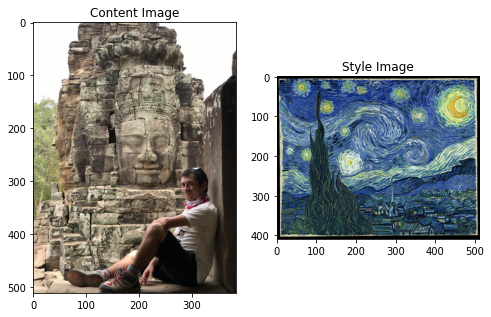

In [140]:
plt.figure(figsize=(8,8))
content = load_file(content_image_path)
style = load_file(style_image_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

### 3. Transform data to use on the model

Define functions to transform the image to a tensor vgg19 model and viceversa.

In [141]:
def preprocess_image(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

def deprocess_image(processed_img):
    # Util function to convert a tensor into a valid image
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3
    #Input dimension must be [1, height, width, channel] or [height, width, channel]
 
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

### 4. Load the VGG19 model

We need the layers to use from vgg19 model

In [142]:
# List of layers to use for the style loss.
style_layers_name = ['block1_conv1',
                     'block2_conv1',
                     'block3_conv1',
                     'block4_conv1',
                     'block5_conv1']

# The layer to use for the content loss.
content_layers_name =['block5_conv2']

number_style_layers =len(style_layers_name)
number_content_layers =len(content_layers_name)

Let's create a feature extraction model that catch the layers we use to create our process.

In [143]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
def get_model():
    model_vgg = vgg19.VGG19(weights="imagenet", include_top=False)
    model_vgg.trainable = False
    content_outputs=[model_vgg.get_layer(layer).output for layer in content_layers_name]
    style_outputs=[model_vgg.get_layer(layer).output for layer in style_layers_name]
    model_outputs= style_outputs + content_outputs
    return models.Model(model_vgg.input, model_outputs)

A summary from VGG19 model

In [144]:
cnn_model=get_model()
cnn_model.summary()

Model: "model_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


The get_features function takes the useful layers from the content and style image 

In [145]:
def get_features(model, content_path, style_path):
    content_img=preprocess_image(content_path)
    style_image=preprocess_image(style_path)
    
    content_outputs=model(content_img)
    style_outputs=model(style_image)
    
    content_feature = [layer[0] for layer in content_outputs[number_style_layers:]]
    style_feature = [layer[0] for layer in style_outputs[:number_style_layers]]
    return style_feature, content_feature

###  5. Compute the style transfer loss

First, we need to define 2 utils functions:

- The `style_loss` function, which keeps the generated image close to the local textures of the style reference image. To calculate style loss, it neccessary to define - `gram_matrix` (used to compute the style loss)

- The `content_loss` function, which keeps the high-level representation of the generated image close to that of the base image


In [146]:
# Essentially content loss captures the root mean squared error between the activations produced 
# by the generated image and the content image.
def content_losses(content, generated):
    return tf.reduce_sum(tf.square(generated - content))

# Style loss
# The style loss is designed to maintain the style of the style image in the generated image.
# It is based on the gram matrices (which capture style) of feature maps from the style image and generated image

# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    vector = tf.reshape(tensor,[-1, channels])
    n = tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector, vector, transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

def style_losses(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target) #Change definition
    loss=tf.reduce_sum(tf.square(target - gram_noise))
    return loss

The next step is to compute the sum of the losses in `compute_loss` function.

In [147]:
def compute_loss(model, loss_weights, image, gram_style_features, content_features):
    #style weight and content weight are given parameters by user
    #defines the percentage of content and/or style will be preserved in the generated image
    style_weight, content_weight = loss_weights 
    
    output=model(image)  
    style_output_features = output[:number_style_layers]
    content_output_feature = output[number_style_layers:]

    content_loss=0
    style_loss=0
    
    weight_per_layer = 1.0/float(number_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_loss += weight_per_layer*style_losses(comb_style[0],target_style)
        
    weight_per_layer =1.0/float(number_content_layers)
    for target_content, comb_content in zip(content_features, content_output_feature):
        content_loss += weight_per_layer*content_losses(comb_content[0],target_content)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    return total_loss, style_loss, content_loss

### 6. Define function to calculate gradient

In [148]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss, dictionary['image']), all_loss

### 7. The training loop

Repeatedly run Adam Optimizer to minimize the loss, and save the resulting image every 250 iterations.


In [149]:
def run_style_transfer(content_path, style_path, epochs=500, content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    style_feature, content_feature = get_features(model, content_path, style_path)
    style_gram_matrix = [gram_matrix(feature) for feature in style_feature]
    
    noise = preprocess_image(content_path)
    noise = tf.Variable(noise, dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    best_loss, best_img = float('inf'), None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
        
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    for i in range(1, epochs+1):
        grad, all_loss = compute_grads(dictionary)
        total_loss, style_loss, content_loss=  all_loss
        optimizer.apply_gradients([(grad, noise)])
        clipped = tf.clip_by_value(noise, min_vals, max_vals)
        noise.assign(clipped)
        print(".", end='', flush=True) #Insert a point in each iteration
        
        if total_loss < best_loss:
            best_loss = total_loss
            best_img = deprocess_image(noise.numpy())
            
        #for visualization   
        if i % 250 == 0:
            plot_img = noise.numpy()
            plot_img = deprocess_image(plot_img)
            print('Epoch: {}, '
              'Loss: {:.3e}, ' 
              'style loss: {:.3e}, '
              'content loss: {:.3e}'.format(i, total_loss, style_loss, content_loss))
        
            fname = result_prefix + "_iter_%d.png" % i
            process_im.save_img(fname, plot_img)
    return best_img, best_loss

### 8. Run the model

the photo results will be store on img folder

In [155]:
best, best_loss = run_style_transfer(content_image_path, style_image_path,  epochs=4000,
                                            content_weight=3e-1, style_weight=9e-7)

..........................................................................................................................................................................................................................................................Epoch: 250, Loss: 1.188e+08, style loss: 4.833e+07, content loss: 7.043e+07
..........................................................................................................................................................................................................................................................Epoch: 500, Loss: 7.457e+07, style loss: 2.800e+07, content loss: 4.657e+07
..........................................................................................................................................................................................................................................................Epoch: 750, Loss: 6.176e+07, style loss: 2.255e+07, content loss: 3.921e+07
......................

### 8. Check the generated image

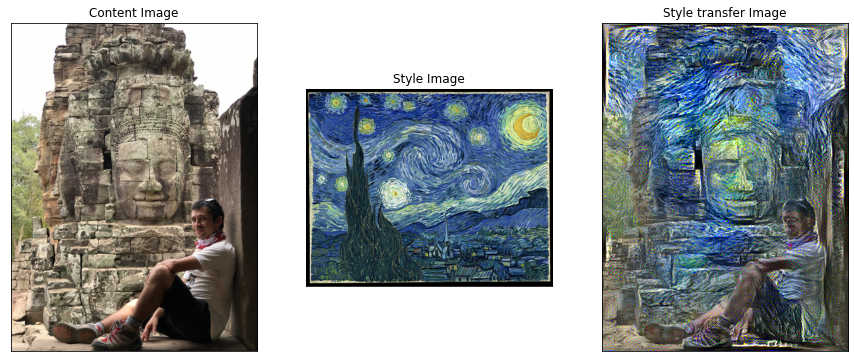

In [156]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()

# A faster way: Use Tensorflow Lite

In [157]:
import tensorflow_hub as hub

Load the model from Tensorflow Lite

In [158]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

Functions to transform an image to a tensor and viceversa

In [159]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)    

Load the content and style image and use the model

In [160]:
content_image = load_img(content_image_path)
style_image = load_img(style_image_path)
generated_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

Save and show the output image

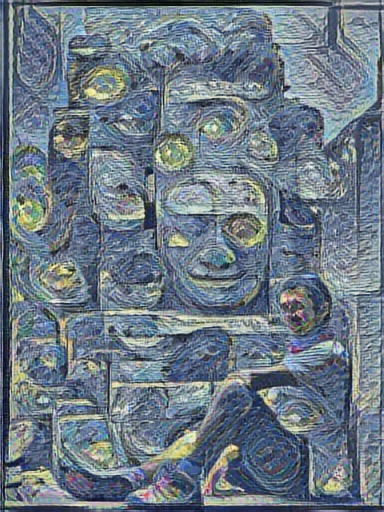

In [162]:
tensor_to_image(generated_image).save('/content/drive/Othercomputers/My PC/neural_transfer/img/gen_img_tsLite.png')
tensor_to_image(generated_image)